# [Sentence-BERT](https://arxiv.org/pdf/1908.10084.pdf)

[Reference Code](https://www.pinecone.io/learn/series/nlp/train-sentence-transformers-softmax/)

In [1]:
import os
import math
import re
from   random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1. Data

### Train, Test, Validation

In [2]:
!pip install datasets

In [3]:
import datasets
snli = datasets.load_dataset('snli')
mnli = datasets.load_dataset('glue', 'mnli')
mnli['train'].features, snli['train'].features

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


({'premise': Value(dtype='string', id=None),
  'hypothesis': Value(dtype='string', id=None),
  'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None),
  'idx': Value(dtype='int32', id=None)},
 {'premise': Value(dtype='string', id=None),
  'hypothesis': Value(dtype='string', id=None),
  'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None)})

In [4]:
# List of datasets to remove 'idx' column from
mnli.column_names.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

In [5]:
# Remove 'idx' column from each dataset
for column_names in mnli.column_names.keys():
    mnli[column_names] = mnli[column_names].remove_columns('idx')

In [6]:
mnli.column_names.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

In [7]:
import numpy as np
np.unique(mnli['train']['label']), np.unique(snli['train']['label'])
#snli also have -1

(array([0, 1, 2]), array([-1,  0,  1,  2]))

In [8]:
# there are -1 values in the label feature, these are where no class could be decided so we remove
snli = snli.filter(
    lambda x: 0 if x['label'] == -1 else 1
)

In [9]:
import numpy as np
np.unique(mnli['train']['label']), np.unique(snli['train']['label'])

(array([0, 1, 2]), array([0, 1, 2]))

In [10]:
# Assuming you have your two DatasetDict objects named snli and mnli
from datasets import DatasetDict
# Merge the two DatasetDict objects
raw_dataset = DatasetDict({
    'train': datasets.concatenate_datasets([snli['train'], mnli['train']]).shuffle(seed=55).select(list(range(10000))),
    'test': datasets.concatenate_datasets([snli['test'], mnli['test_mismatched']]).shuffle(seed=55).select(list(range(1000))),
    'validation': datasets.concatenate_datasets([snli['validation'], mnli['validation_mismatched']]).shuffle(seed=55).select(list(range(1000)))
})
#remove .select(list(range(1000))) in order to use full dataset
# Now, merged_dataset_dict contains the combined datasets from snli and mnli
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 1000
    })
})

## 2. Preprocessing

### 2.1 Construct Tokenizer

In Previous BERT, I tokenized the words and saved in a file 'id2word' but I didn't trained tokenizer from that.So, I will use it as vocab file and train BertTokenizer for S-BERT model training.

In [11]:
import pickle

with open('config.pkl', 'rb') as file:
    config = pickle.load(file)

id2word = config['id2word']

In [12]:
vocab_file = "vocab.txt"
with open(vocab_file, "w", encoding="utf-8") as f:
    for idx in range(len(id2word)):
        f.write(id2word[idx] + "\n")

In [13]:
from transformers import BertTokenizer

# From previous BERT model
max_mask   = config['max_mask']
max_len    = config['max_len']

tokenizer = BertTokenizer(vocab_file="vocab.txt", model_max_length=max_len)

In [14]:
tokens = tokenizer("I lost my love on friday", padding=True, truncation=True)
tokens

{'input_ids': [1, 59, 2946, 304, 125, 301, 4382, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
# save tokenizer for later use
tokenizer.save_pretrained("bert_tokenizer")

('bert_tokenizer/tokenizer_config.json',
 'bert_tokenizer/special_tokens_map.json',
 'bert_tokenizer/vocab.txt',
 'bert_tokenizer/added_tokens.json')

In [16]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert_tokenizer')
tokens = tokenizer("I lost my love on friday", padding=True, truncation=True)
tokens

{'input_ids': [1, 59, 2946, 304, 125, 301, 4382, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

### 2.2 Preprocess and Convert

In [17]:
def preprocess_function(examples):
    max_seq_length = config['max_len']
    padding = 'max_length'
    # Tokenize the premise
    premise_result = tokenizer(
        examples['premise'], padding=padding, max_length=max_seq_length, truncation=True)
    #num_rows, max_seq_length
    # Tokenize the hypothesis
    hypothesis_result = tokenizer(
        examples['hypothesis'], padding=padding, max_length=max_seq_length, truncation=True)
    #num_rows, max_seq_length
    # Extract labels
    labels = examples["label"]
    #num_rows
    return {
        "premise_input_ids": premise_result["input_ids"],
        "premise_attention_mask": premise_result["attention_mask"],
        "hypothesis_input_ids": hypothesis_result["input_ids"],
        "hypothesis_attention_mask": hypothesis_result["attention_mask"],
        "labels" : labels
    }

tokenized_datasets = raw_dataset.map(
    preprocess_function,
    batched=True,
)

tokenized_datasets = tokenized_datasets.remove_columns(['premise','hypothesis','label'])
tokenized_datasets.set_format("torch")

In [18]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 1000
    })
})

## 3. Data loader

In [19]:
from torch.utils.data import DataLoader

# initialize the dataloader
batch_size = 32
train_dataloader = DataLoader(
    tokenized_datasets['train'],
    batch_size=batch_size,
    shuffle=True
)
eval_dataloader = DataLoader(
    tokenized_datasets['validation'],
    batch_size=batch_size
)
test_dataloader = DataLoader(
    tokenized_datasets['test'],
    batch_size=batch_size
)

In [20]:
for batch in train_dataloader:
    print(batch['premise_input_ids'].shape)
    print(batch['premise_attention_mask'].shape)
    print(batch['hypothesis_input_ids'].shape)
    print(batch['hypothesis_attention_mask'].shape)
    print(batch['labels'].shape)
    break

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32])


## 4. Model

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Embedding(nn.Module):
    def __init__(self, vocab_size, max_len, n_segments, d_model, device):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)      # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, x, seg):

        #x, seg: (bs, len)
#         x = torch.clamp(x, 0, self.tok_embed.num_embeddings - 1)
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long).to(self.device)
        pos = pos.unsqueeze(0).expand_as(x)  # (len,) -> (bs, len)
        # Debug device information
        # print(f"x device: {x.device}")
        # print(f"pos device: {pos.device}")
        # print(f"seg device: {seg.device}")
        # print(f"tok_embed weight device: {self.tok_embed.weight.device}")
        # print(f"pos_embed weight device: {self.pos_embed.weight.device}")
        # print(f"seg_embed weight device: {self.seg_embed.weight.device}")

        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)


def get_attn_pad_mask(seq_q, seq_k, device):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1).to(device)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k


class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, d_k, device):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(n_heads, d_model, d_k, device)
        self.pos_ffn       = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn


class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, device):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = torch.sqrt(torch.FloatTensor([d_k])).to(device)

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / self.scale # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_k, device):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_k
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, self.d_v * n_heads)
        self.device = device
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention(self.d_k, self.device)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(self.n_heads * self.d_v, self.d_model, device=self.device)(context)
        return nn.LayerNorm(self.d_model, device=self.device)(output + residual), attn # output: [batch_size x len_q x d_model]


class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(F.gelu(self.fc1(x)))


class BERT(nn.Module):
    def __init__(self, n_layers, n_heads, d_model, d_ff, d_k, n_segments, vocab_size, max_len, device):
        super(BERT, self).__init__()
        self.params = {'n_layers': n_layers, 'n_heads': n_heads, 'd_model': d_model,
                       'd_ff': d_ff, 'd_k': d_k, 'n_segments': n_segments,
                       'vocab_size': vocab_size, 'max_len': max_len}
        self.embedding = Embedding(vocab_size, max_len, n_segments, d_model, device)
        self.layers = nn.ModuleList([EncoderLayer(n_heads, d_model, d_ff, d_k, device) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))
        self.device = device

    def forward(self, input_ids, segment_ids, masked_pos):
        # input_ids = input_ids.to(self.embedding.tok_embed.weight.device)
        # segment_ids = segment_ids.to(self.embedding.tok_embed.weight.device)
        # masked_pos = masked_pos.to(self.embedding.tok_embed.weight.device)


        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]

        # 1. predict next sentence
        # it will be decided by first token(CLS)
        h_pooled   = self.activ(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_nsp = self.classifier(h_pooled) # [batch_size, 2]

        # 2. predict the masked token
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked  = self.norm(F.gelu(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return output, logits_lm, logits_nsp

In [22]:
n_layers = config['n_layers']
n_heads  = config['n_heads']
d_model  = config['d_model']
d_ff = config['d_ff']
d_k = config['d_k']
d_v = config['d_v']
n_segments = config['n_segments']
max_len = config['max_len']
max_mask = config['max_mask']
vocab_size = config['vocab_size']


model = BERT(
    n_layers,
    n_heads,
    d_model,
    d_ff,
    d_k,
    n_segments,
    vocab_size,
    max_len,
    device
).to(device)
model.load_state_dict(torch.load('bert_model.pth'))
model

<ipython-input-22-dc3eca2e88e2>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('bert_model.pth'))


BERT(
  (embedding): Embedding(
    (tok_embed): Embedding(60447, 768)
    (pos_embed): Embedding(512, 768)
    (seg_embed): Embedding(2, 768)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (enc_self_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=512, bias=True)
        (W_K): Linear(in_features=768, out_features=512, bias=True)
        (W_V): Linear(in_features=768, out_features=512, bias=True)
      )
      (pos_ffn): PoswiseFeedForwardNet(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (fc): Linear(in_features=768, out_features=768, bias=True)
  (activ): Tanh()
  (linear): Linear(in_features=768, out_features=768, bias=True)
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
  (decod

### Pooling
SBERT adds a pooling operation to the output of BERT / RoBERTa to derive a fixed sized sentence embedding

In [23]:
# define mean pooling function
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

## 5. Loss Function

## Classification Objective Function
We concatenate the sentence embeddings $u$ and $v$ with the element-wise difference  $\lvert u - v \rvert $ and multiply the result with the trainable weight  $ W_t ∈  \mathbb{R}^{3n \times k}  $:

$ o = \text{softmax}\left(W^T \cdot \left(u, v, \lvert u - v \rvert\right)\right) $

where $n$ is the dimension of the sentence embeddings and k the number of labels. We optimize cross-entropy loss. This structure is depicted in Figure 1.

## Regression Objective Function.
The cosine similarity between the two sentence embeddings $u$ and $v$ is computed (Figure 2). We use means quared-error loss as the objective function.

(Manhatten / Euclidean distance, semantically  similar sentences can be found.)

<img src="./figures/sbert-architecture.png" >

In [24]:
def configurations(u,v):
    # build the |u-v| tensor
    uv = torch.sub(u, v)   # batch_size,hidden_dim
    uv_abs = torch.abs(uv) # batch_size,hidden_dim

    # concatenate u, v, |u-v|
    x = torch.cat([u, v, uv_abs], dim=-1) # batch_size, 3*hidden_dim
    return x

def cosine_similarity(u, v):
    dot_product = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    similarity = dot_product / (norm_u * norm_v)
    return similarity

<img src="./figures/sbert-ablation.png" width="350" height="300">

In [25]:
classifier_head = torch.nn.Linear(768*3, 3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
optimizer_classifier = torch.optim.Adam(classifier_head.parameters(), lr=2e-5)

criterion = nn.CrossEntropyLoss()

In [26]:
from transformers import get_linear_schedule_with_warmup

# and setup a warmup for the first ~10% steps
total_steps = int(len(raw_dataset) / batch_size)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps,
    num_training_steps=total_steps - warmup_steps
)

# then during the training loop we update the scheduler per step
scheduler.step()

scheduler_classifier = get_linear_schedule_with_warmup(
    optimizer_classifier, num_warmup_steps=warmup_steps,
    num_training_steps=total_steps - warmup_steps
)

# then during the training loop we update the scheduler per step
scheduler_classifier.step()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


## 6. Training

In [27]:
from tqdm.auto import tqdm

losses = []
num_epoch = 3
# 1 epoch should be enough, increase if wanted
for epoch in range(num_epoch):
    model.train()
    classifier_head.train()
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    for step, batch in enumerate(tqdm(train_dataloader, leave=True)):
        # zero all gradients on each new step
        optimizer.zero_grad()
        optimizer_classifier.zero_grad()

        # prepare batches and more all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['labels'].to(device)
        segment_ids = torch.tensor([0] * max_len).unsqueeze(0).repeat(inputs_ids_a.shape[0], 1).to(device)
        masked_pos = torch.tensor([0] * max_mask).unsqueeze(0).repeat(inputs_ids_a.shape[0], 1).to(device)

        # extract token embeddings from BERT at last_hidden_state
        u, _, _ = model(inputs_ids_a, segment_ids, masked_pos)
        v, _, _ = model(inputs_ids_b, segment_ids, masked_pos)

        u_last_hidden_state = u # all token embeddings A = batch_size, seq_len, hidden_dim
        v_last_hidden_state = v # all token embeddings B = batch_size, seq_len, hidden_dim

         # get the mean pooled vectors
        u_mean_pool = mean_pool(u_last_hidden_state, attention_a) # batch_size, hidden_dim
        v_mean_pool = mean_pool(v_last_hidden_state, attention_b) # batch_size, hidden_dim

        # build the |u-v| tensor
        uv = torch.sub(u_mean_pool, v_mean_pool)   # batch_size,hidden_dim
        uv_abs = torch.abs(uv) # batch_size,hidden_dim

        # concatenate u, v, |u-v|
        x = torch.cat([u_mean_pool, v_mean_pool, uv_abs], dim=-1) # batch_size, 3*hidden_dim

        # process concatenated tensor through classifier_head
        x = classifier_head(x) #batch_size, classifer
        x = torch.softmax(x, dim=1)

        # calculate the 'softmax-loss' between predicted and true label
        loss = criterion(x, label)
        losses.append(loss.item())  # Save loss value

        # using loss, calculate gradients and then optimizerize
        loss.backward()
        optimizer.step()
        optimizer_classifier.step()

        scheduler.step() # update learning rate scheduler
        scheduler_classifier.step()

    print(f'Epoch: {epoch + 1} | loss = {loss.item():.6f}')

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | loss = 1.170071


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | loss = 1.174322


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | loss = 1.270205


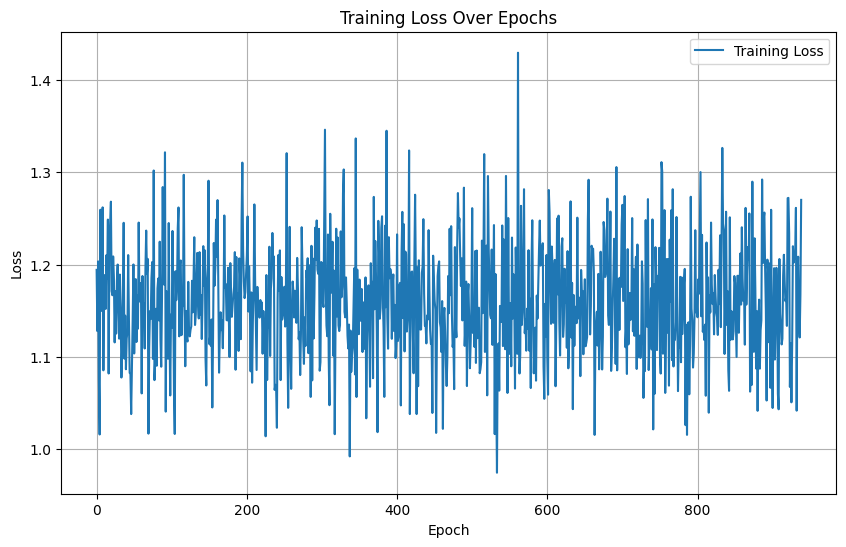

In [28]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [29]:
model.eval()
classifier_head.eval()
total_similarity = 0
with torch.no_grad():
    for step, batch in enumerate(eval_dataloader):
        # prepare batches and more all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['labels'].to(device)

        segment_ids = torch.tensor([0] * max_len).unsqueeze(0).repeat(inputs_ids_a.shape[0], 1).to(device)
        masked_pos = torch.tensor([0] * max_mask).unsqueeze(0).repeat(inputs_ids_a.shape[0], 1).to(device)

        # extract token embeddings from BERT at last_hidden_state
        u, _, _ = model(inputs_ids_a, segment_ids, masked_pos)  # all token embeddings A = batch_size, seq_len, hidden_dim
        v, _, _ = model(inputs_ids_b, segment_ids, masked_pos)  # all token embeddings B = batch_size, seq_len, hidden_dim

        # get the mean pooled vectors
        u_mean_pool = mean_pool(u, attention_a).detach().cpu().numpy().reshape(-1) # batch_size, hidden_dim
        v_mean_pool = mean_pool(v, attention_b).detach().cpu().numpy().reshape(-1) # batch_size, hidden_dim

        similarity_score = cosine_similarity(u_mean_pool, v_mean_pool)
        total_similarity += similarity_score

average_similarity = total_similarity / len(eval_dataloader)
print(f"Average Cosine Similarity: {average_similarity:.4f}")

Average Cosine Similarity: 0.9921


In [40]:
model.eval()
classifier_head.eval()
correct = 0
with torch.no_grad():
    for step, batch in enumerate(eval_dataloader):
        # prepare batches and more all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['labels'].to(device)

        segment_ids = torch.tensor([0] * max_len).unsqueeze(0).repeat(inputs_ids_a.shape[0], 1).to(device)
        masked_pos = torch.tensor([0] * max_mask).unsqueeze(0).repeat(inputs_ids_a.shape[0], 1).to(device)

        # extract token embeddings from BERT at last_hidden_state
        u, _, _ = model(inputs_ids_a, segment_ids, masked_pos)  # all token embeddings A = batch_size, seq_len, hidden_dim
        v, _, _ = model(inputs_ids_b, segment_ids, masked_pos)  # all token embeddings B = batch_size, seq_len, hidden_dim

        # get the mean pooled vectors
        u_mean_pool = mean_pool(u, attention_a) # batch_size, hidden_dim
        v_mean_pool = mean_pool(v, attention_b) # batch_size, hidden_dim

        # build the |u-v| tensor
        uv = torch.sub(u_mean_pool, v_mean_pool)   # batch_size,hidden_dim
        uv_abs = torch.abs(uv) # batch_size,hidden_dim

        # concatenate u, v, |u-v|
        x = torch.cat([u_mean_pool, v_mean_pool, uv_abs], dim=-1) # batch_size, 3*hidden_dim

        # process concatenated tensor through classifier_head
        x = classifier_head(x) #batch_size, classifer
        x = torch.softmax(x, dim=1)

        predictions = torch.argmax(x, dim=1)  # Shape: [batch_size]

        # Compare predictions with the true labels
        correct = (predictions == label).sum().item()
        total = label.size(0)

average_accuracy = correct / total
print(f"Average accuracy: {average_accuracy:.4f}")

Average accuracy: 0.5000


In [31]:
# Save the model after training
torch.save(classifier_head.state_dict(), 'classifier.pth')
print("Model saved to classifier.pth")

Model saved to classifier.pth


## 7. Inference

In [32]:
import pickle


with open('config.pkl', 'rb') as file:
    config = pickle.load(file)

In [33]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert_tokenizer')
tokens = tokenizer("I lost my love on friday", padding=True, truncation=True)
tokens

{'input_ids': [1, 59, 2946, 304, 125, 301, 4382, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [34]:
n_layers = config['n_layers']
n_heads  = config['n_heads']
d_model  = config['d_model']
d_ff = config['d_ff']
d_k = config['d_k']
d_v = config['d_v']
n_segments = config['n_segments']
max_len = config['max_len']
max_mask = config['max_mask']
vocab_size = config['vocab_size']


model = BERT(
    n_layers,
    n_heads,
    d_model,
    d_ff,
    d_k,
    n_segments,
    vocab_size,
    max_len,
    device
).to(device)
model.load_state_dict(torch.load('bert_model.pth'))
model

<ipython-input-34-dc3eca2e88e2>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('bert_model.pth'))


BERT(
  (embedding): Embedding(
    (tok_embed): Embedding(60447, 768)
    (pos_embed): Embedding(512, 768)
    (seg_embed): Embedding(2, 768)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (enc_self_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=512, bias=True)
        (W_K): Linear(in_features=768, out_features=512, bias=True)
        (W_V): Linear(in_features=768, out_features=512, bias=True)
      )
      (pos_ffn): PoswiseFeedForwardNet(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (fc): Linear(in_features=768, out_features=768, bias=True)
  (activ): Tanh()
  (linear): Linear(in_features=768, out_features=768, bias=True)
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
  (decod

In [35]:
import torch
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(model, tokenizer, sentence_a, sentence_b, device):
    # Tokenize and convert sentences to input IDs and attention masks
    inputs_a = tokenizer(sentence_a, return_tensors='pt', truncation=True, padding = 'max_length').to(device)
    inputs_b = tokenizer(sentence_b, return_tensors='pt', truncation=True, padding = 'max_length').to(device)

    # Move input IDs and attention masks to the active device
    inputs_ids_a = inputs_a['input_ids']
    attention_a = inputs_a['attention_mask']
    inputs_ids_b = inputs_b['input_ids']
    attention_b = inputs_b['attention_mask']

    segment_ids = torch.tensor([0] * max_len).unsqueeze(0).repeat(inputs_ids_a.shape[0], 1).to(device)
    masked_pos = torch.tensor([0] * max_mask).unsqueeze(0).repeat(inputs_ids_a.shape[0], 1).to(device)

    # extract token embeddings from BERT at last_hidden_state
    u, _, _ = model(inputs_ids_a, segment_ids, masked_pos)  # all token embeddings A = batch_size, seq_len, hidden_dim
    v, _, _ = model(inputs_ids_b, segment_ids, masked_pos)  # all token embeddings B = batch_size, seq_len, hidden_dim

    # Get the mean-pooled vectors
    u = mean_pool(u, attention_a).detach().cpu().numpy().reshape(-1)  # batch_size, hidden_dim
    v = mean_pool(v, attention_b).detach().cpu().numpy().reshape(-1)  # batch_size, hidden_dim

    # Calculate cosine similarity
    similarity_score = cosine_similarity(u.reshape(1, -1), v.reshape(1, -1))[0, 0]

    return similarity_score

In [36]:
sentence_a = 'Why there are so many people?'
sentence_b = "There is a boy who is ugly"
similarity = calculate_similarity(model, tokenizer, sentence_a, sentence_b, device)
print(f"Cosine Similarity: {similarity:.4f}")

Cosine Similarity: 0.9906


In [37]:
sentence_a = 'Am I handsome?'
sentence_b = "There is a boy who is ugly"
similarity = calculate_similarity(model, tokenizer, sentence_a, sentence_b, device)
print(f"Cosine Similarity: {similarity:.4f}")

Cosine Similarity: 0.9795


In [38]:
sentence_a = 'She is pretty'
sentence_b = "I know that you are beautiful"
similarity = calculate_similarity(model, tokenizer, sentence_a, sentence_b, device)
print(f"Cosine Similarity: {similarity:.4f}")

Cosine Similarity: 0.9976


In [42]:
def check_relation(model, tokenizer, sentence_a, sentence_b, device):
    # Tokenize and convert sentences to input IDs and attention masks
    inputs_a = tokenizer(sentence_a, return_tensors='pt', truncation=True, padding = 'max_length').to(device)
    inputs_b = tokenizer(sentence_b, return_tensors='pt', truncation=True, padding = 'max_length').to(device)

    # Move input IDs and attention masks to the active device
    inputs_ids_a = inputs_a['input_ids']
    attention_a = inputs_a['attention_mask']
    inputs_ids_b = inputs_b['input_ids']
    attention_b = inputs_b['attention_mask']

    segment_ids = torch.tensor([0] * max_len).unsqueeze(0).repeat(inputs_ids_a.shape[0], 1).to(device)
    masked_pos = torch.tensor([0] * max_mask).unsqueeze(0).repeat(inputs_ids_a.shape[0], 1).to(device)

    # extract token embeddings from BERT at last_hidden_state
    u, _, _ = model(inputs_ids_a, segment_ids, masked_pos)  # all token embeddings A = batch_size, seq_len, hidden_dim
    v, _, _ = model(inputs_ids_b, segment_ids, masked_pos)  # all token embeddings B = batch_size, seq_len, hidden_dim

    # get the mean pooled vectors
    u_mean_pool = mean_pool(u, attention_a) # batch_size, hidden_dim
    v_mean_pool = mean_pool(v, attention_b) # batch_size, hidden_dim

    # build the |u-v| tensor
    uv = torch.sub(u_mean_pool, v_mean_pool)   # batch_size,hidden_dim
    uv_abs = torch.abs(uv) # batch_size,hidden_dim

    # concatenate u, v, |u-v|
    x = torch.cat([u_mean_pool, v_mean_pool, uv_abs], dim=-1) # batch_size, 3*hidden_dim

    # process concatenated tensor through classifier_head
    x = classifier_head(x) #batch_size, classifer
    x = torch.softmax(x, dim=1)

    prediction = torch.argmax(x, dim=1)  # Shape: [batch_size]
    if prediction == 0:
        relation = 'entailment'
    elif prediction == 1:
        relation = 'neutral'
    else:
        relation = 'contradiction'
    return relation

In [49]:
sentence_a = 'I know that you are handsome'
sentence_b = 'Sometime, I am crazy'
relation = check_relation(model, tokenizer, sentence_a, sentence_b, device)
print(f"Relation: {relation}")

Relation: contradiction
